This notebook produces IMF integrated metallicity dependent net yields. As an example we produce the default and alternative tables for the single sun+ best fit (which fix the SSP parameter). This notebook is just an example showing illustratively how to produce these yield tables. If you actually want to use these for your Chemical evolution model you will probably want to increase the time_steps and the mass_steps. You could also consult me to get an idea of sensible Parameters and yield sets that one could use. Mostly those ideas will be based on: http://adsabs.harvard.edu/abs/2018ApJ...861...40P

In [1]:
%pylab inline
import multiprocessing as mp

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Chempy.parameter import ModelParameters
a = ModelParameters()

In [3]:
# Load solar abundances

from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.5,521)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'Nomoto2013_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "Seitenzahl")()
basic_agb = AGB_feedback()
getattr(basic_agb, "Karakas_net_yield")()

# Load the alternative yields
alt_sn2 = SN2_feedback()
getattr(alt_sn2, 'chieffi04_net')()
alt_1a = SN1a_feedback()
getattr(alt_1a, "Thielemann")()
alt_agb = AGB_feedback()
getattr(alt_agb, "Ventura")()

# Use all elements that are traced

elements_to_trace = list(np.unique(basic_agb.elements+basic_sn2.elements+basic_1a.elements+alt_agb.elements+alt_sn2.elements+alt_1a.elements))
#elements_to_trace = ['H','He','C','N','O','Na','Al','Mg','Si','Ca','Ti','Mn','Fe','Ba','Ne']
print('all the traced elements: ',elements_to_trace)

# Producing the SSP birth elemental fractions (here we use solar)

solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))



all the traced elements:  ['Al', 'Ar', 'As', 'B', 'Be', 'Br', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Kr', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Ne', 'Ni', 'O', 'P', 'Rb', 'S', 'Sc', 'Se', 'Si', 'Sr', 'Ti', 'V', 'Y', 'Zn', 'Zr']


/home/rybizki/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [4]:
# yieldset default
a.yield_table_name_sn2 = 'Nomoto2013_net'
a.yield_table_name_agb = 'Karakas_net_yield'
a.yield_table_name_1a = 'Seitenzahl'
# yieldset alternative
#a.yield_table_name_sn2 = 'chieffi04_net'
#a.yield_table_name_agb = 'Ventura'
#a.yield_table_name_1a = 'Thielemann'

# imf parameters
a.only_net_yields_in_process_tables = True
a.imf_type_name = 'Chabrier_2'
#default
a.high_mass_slope = -2.46
#alternative
#a.high_mass_slope = -2.51
a.imf_parameter = (22.8978, 716.4, 0.25, a.high_mass_slope)
a.mmin = 0.1
a.mmax = 100
# 100,000,000 mass steps are smooth enough for 1000 time steps
a.mass_steps = 200000 #2000 # 200000
a.sn2mmin = 8.
a.sn2mmax = 100.
a.bhmmin = float(a.sn2mmax) ## maximum of hypernova
a.bhmmax = float(a.mmax) ## maximum of the IMF

# sn1a delay parameters for maoz
#default
a.N_0 = np.power(10,-3.07)
a.sn1a_time_delay = np.power(10,-0.8)
#alternative
#a.N_0 = np.power(10,-3.49)
#a.sn1a_time_delay = np.power(10,-0.88)

a.sn1a_exponent = 1.12
a.dummy = 0.0
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

In [5]:
list_of_metallicities = np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap


def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    print(metallicity,a.yield_table_name_sn2)
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [6]:
print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)
np.save('data/paper_1_ssp_tables/SSP_tables_default', list_of_SSP_tables)

There are 4 CPUs on this machine
0.01 Nomoto2013_net
0.0001 Nomoto2013_net


In [7]:
print('the metallicities for which SSP yield tables were calculated: ',list_of_SSP_tables[0])
print('metallicities: ',len(list_of_SSP_tables[2]))
print('timesteps: ', len(list_of_SSP_tables[2][0]), '= ', len(list_of_SSP_tables[1]))

the metallicities for which SSP yield tables were calculated:  [ 0.0001  0.01  ]
metallicities:  2
timesteps:  521 =  521


In [8]:
print('the data type of the SSP yield table: ',list_of_SSP_tables[2][0].dtype)
x = list_of_SSP_tables[2][0]
z = list_of_SSP_tables[2][1]

the data type of the SSP yield table:  (numpy.record, [('mass_of_ms_stars_dying', '<f8'), ('mass_in_ms_stars', '<f8'), ('mass_in_remnants', '<f8'), ('sn2', '<f8'), ('sn1a', '<f8'), ('pn', '<f8'), ('bh', '<f8'), ('hydrogen_mass_accreted_onto_white_dwarfs', '<f8'), ('unprocessed_ejecta', '<f8'), ('Al', '<f8'), ('Ar', '<f8'), ('As', '<f8'), ('B', '<f8'), ('Be', '<f8'), ('Br', '<f8'), ('C', '<f8'), ('Ca', '<f8'), ('Cl', '<f8'), ('Co', '<f8'), ('Cr', '<f8'), ('Cu', '<f8'), ('F', '<f8'), ('Fe', '<f8'), ('Ga', '<f8'), ('Ge', '<f8'), ('H', '<f8'), ('He', '<f8'), ('K', '<f8'), ('Kr', '<f8'), ('Li', '<f8'), ('Mg', '<f8'), ('Mn', '<f8'), ('Mo', '<f8'), ('N', '<f8'), ('Na', '<f8'), ('Nb', '<f8'), ('Ne', '<f8'), ('Ni', '<f8'), ('O', '<f8'), ('P', '<f8'), ('Rb', '<f8'), ('S', '<f8'), ('Sc', '<f8'), ('Se', '<f8'), ('Si', '<f8'), ('Sr', '<f8'), ('Ti', '<f8'), ('V', '<f8'), ('Y', '<f8'), ('Zn', '<f8'), ('Zr', '<f8')])


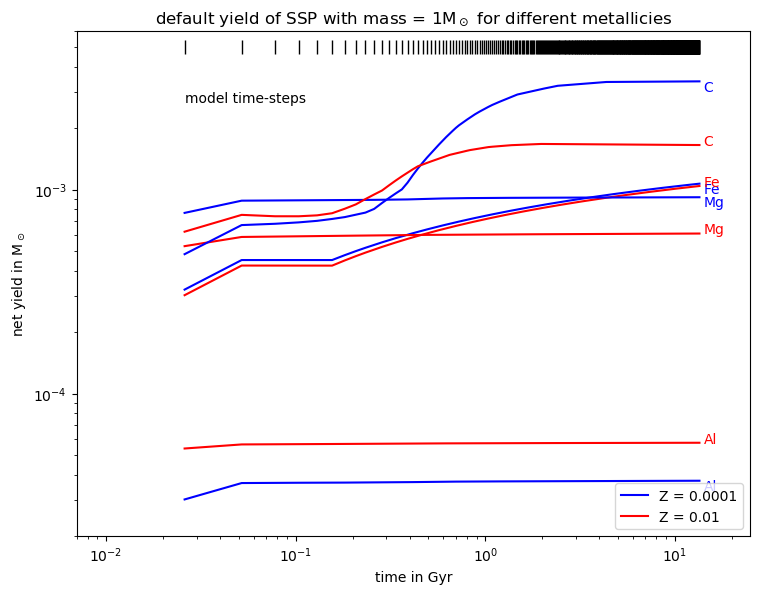

In [9]:
alpha = 0.5
factor = 1.05

## Actual plotting

fig = plt.figure(figsize=(8.69,6.69), dpi=100)
ax = fig.add_subplot(111)
ax.plot(time_steps,np.cumsum(x["Fe"]),'b', label = 'Z = 0.0001')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Fe"])*0.9) ,s = 'Fe',color = 'b')
ax.plot(time_steps,np.cumsum(z["Fe"]), 'r', label = 'Z = 0.01')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Fe"])) ,s = 'Fe',color = 'r')

ax.plot(time_steps,np.cumsum(x["Mg"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Mg"])*0.9) ,s = 'Mg',color = 'b')
ax.plot(time_steps,np.cumsum(z["Mg"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Mg"])) ,s = 'Mg',color = 'r')

ax.plot(time_steps,np.cumsum(x["Al"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Al"])*0.9) ,s = 'Al',color = 'b')
ax.plot(time_steps,np.cumsum(z["Al"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Al"])) ,s = 'Al',color = 'r')

ax.plot(time_steps,np.cumsum(x["C"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["C"])*0.9) ,s = 'C',color = 'b')
ax.plot(time_steps,np.cumsum(z["C"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["C"])) ,s = 'C',color = 'r')

ax.plot(time_steps,np.ones_like(time_steps)*5e-3,marker = '|', markersize = 10, linestyle = '', color = 'k', alpha = 2*alpha)#, label = 'time-steps')
ax.annotate(xy = (time_steps[1],2.7e-3),s = 'model time-steps', color = 'k', alpha = 2*alpha)
ax.legend(loc = 'best')

ax.set_ylim(2e-5,6e-3)
ax.set_xlim(7e-3,25)
ax.set_title(r'default yield of SSP with mass = 1M$_\odot$ for different metallicies')
ax.set_ylabel(r"net yield in M$_\odot$")
ax.set_xlabel("time in Gyr")

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [10]:
# yieldset alternative
a.yield_table_name_sn2 = 'chieffi04_net'
a.yield_table_name_agb = 'Ventura'
a.yield_table_name_1a = 'Thielemann'

a.high_mass_slope = -2.51
a.imf_parameter = (22.8978, 716.4, 0.25, a.high_mass_slope)
a.N_0 = np.power(10,-3.49)
a.sn1a_time_delay = np.power(10,-0.88)
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

list_of_SSP_tables_alt = []
list_of_SSP_tables_alt.append(list_of_metallicities)
list_of_SSP_tables_alt.append(time_steps)

print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables_alt.append(results)
np.save('data/paper_1_ssp_tables/SSP_tables_alternative', list_of_SSP_tables_alt)

There are 4 CPUs on this machine
0.0001 chieffi04_net
0.01 chieffi04_net


/home/rybizki/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))
/home/rybizki/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [11]:
print('the data type of the SSP yield table: ',list_of_SSP_tables[2][0].dtype)
y = list_of_SSP_tables_alt[2][1]

the data type of the SSP yield table:  (numpy.record, [('mass_of_ms_stars_dying', '<f8'), ('mass_in_ms_stars', '<f8'), ('mass_in_remnants', '<f8'), ('sn2', '<f8'), ('sn1a', '<f8'), ('pn', '<f8'), ('bh', '<f8'), ('hydrogen_mass_accreted_onto_white_dwarfs', '<f8'), ('unprocessed_ejecta', '<f8'), ('Al', '<f8'), ('Ar', '<f8'), ('As', '<f8'), ('B', '<f8'), ('Be', '<f8'), ('Br', '<f8'), ('C', '<f8'), ('Ca', '<f8'), ('Cl', '<f8'), ('Co', '<f8'), ('Cr', '<f8'), ('Cu', '<f8'), ('F', '<f8'), ('Fe', '<f8'), ('Ga', '<f8'), ('Ge', '<f8'), ('H', '<f8'), ('He', '<f8'), ('K', '<f8'), ('Kr', '<f8'), ('Li', '<f8'), ('Mg', '<f8'), ('Mn', '<f8'), ('Mo', '<f8'), ('N', '<f8'), ('Na', '<f8'), ('Nb', '<f8'), ('Ne', '<f8'), ('Ni', '<f8'), ('O', '<f8'), ('P', '<f8'), ('Rb', '<f8'), ('S', '<f8'), ('Sc', '<f8'), ('Se', '<f8'), ('Si', '<f8'), ('Sr', '<f8'), ('Ti', '<f8'), ('V', '<f8'), ('Y', '<f8'), ('Zn', '<f8'), ('Zr', '<f8')])


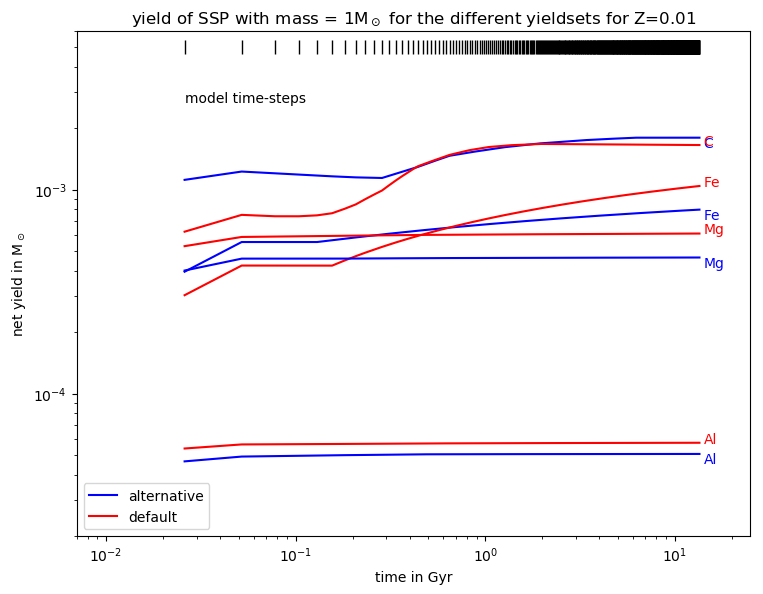

In [12]:
## Actual plotting

fig = plt.figure(figsize=(8.69,6.69), dpi=100)
ax = fig.add_subplot(111)
ax.plot(time_steps,np.cumsum(y["Fe"]),'b', label = 'alternative')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["Fe"])*0.9) ,s = 'Fe',color = 'b')
ax.plot(time_steps,np.cumsum(z["Fe"]), 'r', label = 'default')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Fe"])) ,s = 'Fe',color = 'r')

ax.plot(time_steps,np.cumsum(y["Mg"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["Mg"])*0.9) ,s = 'Mg',color = 'b')
ax.plot(time_steps,np.cumsum(z["Mg"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Mg"])) ,s = 'Mg',color = 'r')

ax.plot(time_steps,np.cumsum(y["Al"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["Al"])*0.9) ,s = 'Al',color = 'b')
ax.plot(time_steps,np.cumsum(z["Al"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["Al"])) ,s = 'Al',color = 'r')

ax.plot(time_steps,np.cumsum(y["C"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(y["C"])*0.9) ,s = 'C',color = 'b')
ax.plot(time_steps,np.cumsum(z["C"]), 'r')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(z["C"])) ,s = 'C',color = 'r')

ax.plot(time_steps,np.ones_like(time_steps)*5e-3,marker = '|', markersize = 10, linestyle = '', color = 'k', alpha = 2*alpha)#, label = 'time-steps')
ax.annotate(xy = (time_steps[1],2.7e-3),s = 'model time-steps', color = 'k', alpha = 2*alpha)
ax.legend(loc = 'best')

ax.set_ylim(2e-5,6e-3)
ax.set_xlim(7e-3,25)
ax.set_title(r'yield of SSP with mass = 1M$_\odot$ for the different yieldsets for Z=0.01')
ax.set_ylabel(r"net yield in M$_\odot$")
ax.set_xlabel("time in Gyr")

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

Beware, that both yieldsets for optimized to reproduce solar abundances, so in fact they look more similar here than they actually are, because the IMF and SNIa contribution is different. If you want to see the difference for the same SSP parameters check Paper 1 figure 4.